In [1]:
from bs4 import BeautifulSoup
import fileinput
import sys
import re
import csv
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines


### Scraping Data from Federal Reserve:
#### Explanations / Guidelines:
- All files are saved in current directory
- We will be analyzing "Figure_7.D._TransRisk_Score_Cumulative_Percentage_of_Goods_and_Bads,_by_Demographic_Group(Random-Account_Performance)_-_Race_or_ethnicity_(SSA_data).csv" and saving that file as 'random-account-ficoscores.csv' for easier reference
- To analyze the Cumulative Percentage of Goods and Bads for any of the other protected groups (sex, age, marital status, or income ratio) simply plug in this csv when assigning the 'data' variable
- Options for account types: any-account, new-account, existing-account, random-account
- In this study, "good" means non-defaulting for loans (will pay it off). "Bad" means defaulting for loans (will not pay it off).

In [12]:

url = "www.federalreserve.gov/boarddocs/rptcongress/creditscore/overviewfigtables.htm"
r  = requests.get("https://" +url)
data = r.text
soup = BeautifulSoup(data, 'lxml')


def cell_text(cell):
    return " ".join(cell.stripped_strings)

for table in soup.find_all('table'):
    title = table.find('span', { 'class' : 'tablehead' }).getText()
    subhead = table.find('span', { 'class' : 'tablesubheadsmall' }).getText()
#     print(title, subhead)
    fname = (title + ' - '+subhead).replace(' ', '_') + '.csv'
    fname = fname.replace(':', '-')
    with open(fname, 'w') as outfile:
        output = csv.writer(outfile)

        for row in table.find_all('tr'):
            col = map(cell_text, row.find_all(re.compile('t[dh]')))
            output.writerow(col)
            


In [13]:
# options of data to analyze
# os.rename('Figure_7.A._TransRisk_Score-_Cumulative_Percentage_of_Goods_and_Bads,_by_Demographic_Group(Any-Account_Performance)_-_Race_or_ethnicity_(location-based_distribution).csv', 'any-account-ficoscores.csv')
# os.rename('Figure_7.A._TransRisk_Score-_Cumulative_Percentage_of_Goods_and_Bads,_by_Demographic_Group(Any-Account_Performance)_-_Race_or_ethnicity_(SSA_data).csv', 'any-account-ficoscores-ssa.csv')
# os.rename('Figure_7.B._TransRisk_Score-_Cumulative_Percentage_of_Goods_and_Bads,_by_Demographic_Group(New-Account_Performance)_-_Race_or_ethnicity_(location-based_distribution).csv', 'new-account-ficoscores.csv')
os.rename('Figure_7.D._TransRisk_Score-_Cumulative_Percentage_of_Goods_and_Bads,_by_Demographic_Group(Random-Account_Performance)_-_Race_or_ethnicity_(SSA_data).csv', 'random-account-ficoscores.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Figure_7.D._TransRisk_Score-_Cumulative_Percentage_of_Goods_and_Bads,_by_Demographic_Group(Random-Account_Performance)_-_Race_or_ethnicity_(SSA_data).csv' -> 'random-account-ficoscores.csv'

In [14]:
data = pd.read_csv("random-account-ficoscores.csv")
#Necessary to rename this column for clarity of the data it represents
#because of formatting issues when parsing data from the html
data.rename(columns={'Black (Bad).1':'Hispanic (Good)'}, inplace=True)

In [19]:
#only for white race:
white_non_default = data[["Score", "Non- Hispanic white (Good)"]]
white_default = data[["Score","Non- Hispanic white (Bad)"]]
black_non_default = data[["Score","Black (Good)"]]
black_default = data[["Score","Black (Bad)"]]
hispanic_non_default = data[["Score","Hispanic (Good)"]]
hispanic_default = data[["Score","Hispanic (Bad)"]]
asian_non_default = data[["Score","Asian (Good)"]]
asian_default = data[["Score","Asian (Bad)"]]

In [26]:
def getGraph(dataset, metricName, graphType):
    i= 0
    x = []
    y = []
    while(i < 100.5):
        if(i == 72.5 or i == 77.5 or i == 92.5):
            i = (i + 0.5)
        curr_race_non_default = dataset[dataset["Score"] >= i][metricName].sum()
        total_race_non_default = dataset[metricName].sum()
        yVal = curr_race_non_default / total_race_non_default
        x.append(i)
        y.append(yVal)
        i = (i + 0.5)
    plt.plot(x, y, graphType, label=metricName)


def getGraphYEqualsZero(dataset, metricName, graphType):
    i= 0
    x = []
    y = []
    while(i < 100.5):
        if(i == 72.5 or i == 77.5 or i == 92.5):
            i = (i + 0.5)
        curr_race_num = dataset[dataset["Score"] >= i][metricName].sum()
        total_race_num = dataset[metricName].sum()
        yVal = (total_race_num - curr_race_num) / total_race_num
        x.append(i)
        y.append(yVal)
        i = (i + 0.5)
    plt.plot(x, y, graphType)

getGraphYEqualsZero(hispanic_non_default, "Hispanic (Good)", 'm-')
getGraphYEqualsZero(hispanic_default, "Hispanic (Bad)", 'r-')
plt.title("Hispanic Probability of $\hat Y$ = 0")

purple_line = mlines.Line2D([], [], color='purple', marker='.',
                          markersize=15, label='Non Defaulters')
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Defaulters')
plt.legend(handles=[purple_line, red_line])

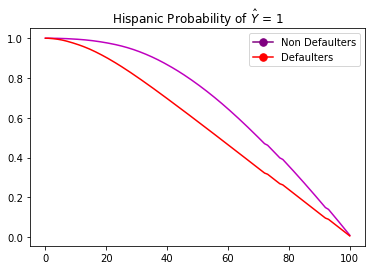

In [30]:
getGraph(hispanic_non_default, "Hispanic (Good)", 'm-')
getGraph(hispanic_default, "Hispanic (Bad)", 'r-')
plt.title("Hispanic Probability of $\hat Y$ = 1")

purple_line = mlines.Line2D([], [], color='purple', marker='.',
                          markersize=15, label='Non Defaulters')
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Defaulters')
plt.legend(handles=[purple_line, red_line])

getGraphYEqualsZero(black_non_default, "Black (Good)", 'c-')
getGraphYEqualsZero(black_default, "Black (Bad)", 'r-')
plt.title("Black Probability of $\hat Y$ = 0")

purple_line = mlines.Line2D([], [], color='cyan', marker='.',
                          markersize=15, label='Non Defaulters')
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Defaulters')
plt.legend(handles=[purple_line, red_line])

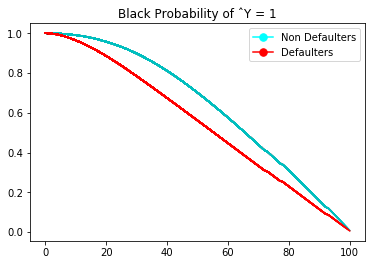

In [11]:
getGraph(black_non_default, "Black (Good)", 'c-')
getGraph(black_default, "Black (Bad)", 'r-')
plt.title("Black Probability of $\hat Y$ = 1")

purple_line = mlines.Line2D([], [], color='cyan', marker='.',
                          markersize=15, label='Non Defaulters')
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Defaulters')
plt.legend(handles=[purple_line, red_line])

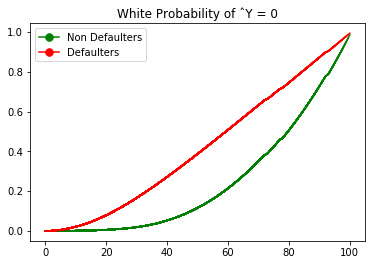

In [13]:
getGraphYEqualsZero(white_non_default, "Non- Hispanic white (Good)", 'g-')
getGraphYEqualsZero(white_default, "Non- Hispanic white (Bad)", 'r-')
plt.title("White Probability of $\hat Y$ = 0")

purple_line = mlines.Line2D([], [], color='green', marker='.',
                          markersize=15, label='Non Defaulters')
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Defaulters')
plt.legend(handles=[purple_line, red_line])

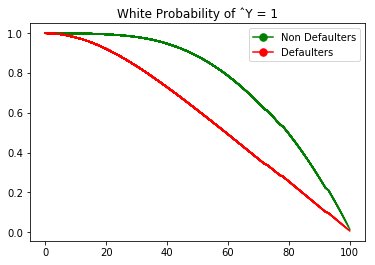

In [14]:
getGraph(white_non_default, "Non- Hispanic white (Good)", 'g-')
getGraph(white_default, "Non- Hispanic white (Bad)", 'r-')
plt.title("White Probability of $\hat Y$ = 1")

purple_line = mlines.Line2D([], [], color='green', marker='.',
                          markersize=15, label='Non Defaulters')
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Defaulters')
plt.legend(handles=[purple_line, red_line])

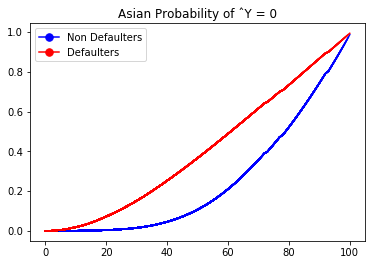

In [15]:
getGraphYEqualsZero(asian_non_default, "Asian (Good)", 'b-')
getGraphYEqualsZero(asian_default, "Asian (Bad)", 'r-')
plt.title("Asian Probability of $\hat Y$ = 0")

purple_line = mlines.Line2D([], [], color='blue', marker='.',
                          markersize=15, label='Non Defaulters')
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Defaulters')
plt.legend(handles=[purple_line, red_line])

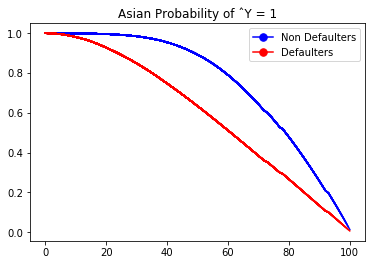

In [16]:
getGraph(asian_non_default, "Asian (Good)", 'b-')
getGraph(asian_default, "Asian (Bad)", 'r-')
plt.title("Asian Probability of $\hat Y$ = 1")

purple_line = mlines.Line2D([], [], color='blue', marker='.',
                          markersize=15, label='Non Defaulters')
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Defaulters')
plt.legend(handles=[purple_line, red_line])

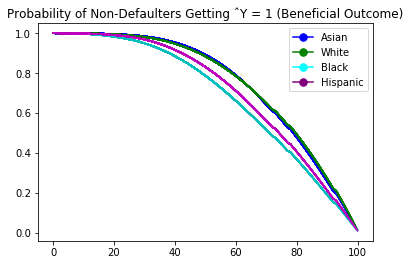

In [17]:
getGraph(asian_non_default, "Asian (Good)", 'b-')
getGraph(white_non_default, "Non- Hispanic white (Good)", 'g-')
getGraph(black_non_default, "Black (Good)", 'c-')
getGraph(hispanic_non_default, "Hispanic (Good)", 'm-')
plt.title("Probability of Non-Defaulters Getting $\hat Y$ = 1 (Beneficial Outcome)" )


blue_line = mlines.Line2D([], [], color='blue', marker='.',
                          markersize=15, label='Asian')
green_line = mlines.Line2D([], [], color='green', marker='.',
                          markersize=15, label='White')
cyan_line = mlines.Line2D([], [], color='cyan', marker='.',
                          markersize=15, label='Black')
purple_line = mlines.Line2D([], [], color='purple', marker='.',
                          markersize=15, label='Hispanic')

plt.legend(handles=[blue_line, green_line, cyan_line, purple_line])

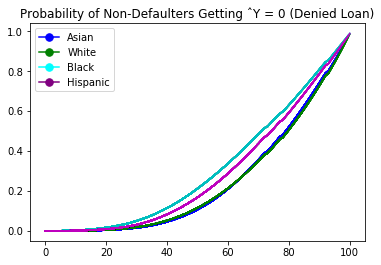

In [18]:
getGraphYEqualsZero(asian_non_default, "Asian (Good)", 'b-')
getGraphYEqualsZero(white_non_default, "Non- Hispanic white (Good)", 'g-')
getGraphYEqualsZero(black_non_default, "Black (Good)", 'c-')
getGraphYEqualsZero(hispanic_non_default, "Hispanic (Good)", 'm-')
plt.title("Probability of Non-Defaulters Getting $\hat Y$ = 0 (Denied Loan)" )


blue_line = mlines.Line2D([], [], color='blue', marker='.',
                          markersize=15, label='Asian')
green_line = mlines.Line2D([], [], color='green', marker='.',
                          markersize=15, label='White')
cyan_line = mlines.Line2D([], [], color='cyan', marker='.',
                          markersize=15, label='Black')
purple_line = mlines.Line2D([], [], color='purple', marker='.',
                          markersize=15, label='Hispanic')

plt.legend(handles=[blue_line, green_line, cyan_line, purple_line])

In [19]:
# X Axis is the FICO Score Percentile
# Y Axis is the probabability of obtaining either ˆY = 0 or ˆY = 1
# Threshold that maximizes profit is the score where 82% of people don't default

In [21]:
#same as graphing functions, it just returns data as a pandas df instead of a graphable mathplotlib element
def getAllProbabilities(dataset, metricName):
    i= 0
    x = []
    y = []
    while(i < 100.5):
        if(i == 72.5 or i == 77.5 or i == 92.5):
            i = (i + 0.5)
        curr_race_non_default = dataset[dataset["Score"] >= i][metricName].sum()
        total_race_non_default = dataset[metricName].sum()
        yVal = curr_race_non_default / total_race_non_default
        x.append(i)
        y.append(yVal)
        i = (i + 0.5)
    return pd.DataFrame(
        {'Score': x,
         'Probability of Beneficial Outcome': y
    })

## Max Profit Classifier ##

In [67]:
def getMaxProfit(identifier, dataset, raceMetric, lowerBound, upperBound):
    allProbabilities = getAllProbabilities(dataset, raceMetric)
    above82 = allProbabilities[allProbabilities["Probability of Beneficial Outcome"] > lowerBound]
    whiteMaximizedProfit = above82[above82["Probability of Beneficial Outcome"] < upperBound]
    return (identifier, whiteMaximizedProfit["Score"].values[0])

In [68]:
# Threshold is different for each group
# For each group, pick the threshold that maximizes proft
# This is the score at which 82% of the people do not default (by this do they mean 82% of people who
# don't default get a loan?)

#lower threshold = more false negatives
#pool defaulters and non defaulters together into one

#QUESTION : How would I do this with my current data when I'm looking at people who default entirely separate
#from people who don't default? I went with the assumtion that max profit is 82% of people who don't default get a loan.

maxWhiteProfitScore = getMaxProfit("white", white_non_default, 'Non- Hispanic white (Good)', 0.82, 0.825)
maxBlackProfitScore = getMaxProfit("black", black_non_default, 'Black (Good)', 0.82, 0.825)
maxAsianProfitScore = getMaxProfit("asian", asian_non_default, 'Asian (Good)', 0.80, 0.83)
maxHispanicProfitScore = getMaxProfit("hispanic", hispanic_non_default, 'Hispanic (Good)', 0.82, 0.825)

maxWhiteProfitScore, maxBlackProfitScore, maxAsianProfitScore, maxHispanicProfitScore

(('white', 56.5), ('black', 47.0), ('asian', 57.0), ('hispanic', 51.0))

## Race Blind Classifier ##

In [97]:
# Threshold must be the same for each group
# Pick single threshold where 82% of people do not default overall

#I think this is wrong because all it did was find the probabilities of each race at the threshold of 82.5
#what I am trying to do is somehow concatenate all of the data points so that I can determine what percentage
#of people overall are not getting loans out of the non-defaulting population, then I look at where the total
#is 0.82% and choose the score there.

whiteAll = getAllProbabilities(white_non_default, 'Non- Hispanic white (Good)')
blackAll = getAllProbabilities(black_non_default, 'Black (Good)')
asianAll = getAllProbabilities(asian_non_default, 'Asian (Good)')
hispanicAll = getAllProbabilities(hispanic_non_default, 'Hispanic (Good)')

whiteBlack = pd.merge(blackAll,whiteAll,on='Score')
asianHispanic = pd.merge(asianAll, hispanicAll, on='Score')
finalResult = pd.merge(whiteBlack, asianHispanic, on='Score')
bestScoreForAll = finalResult[finalResult["Score"] == 82.5]
bestScoreForAll = bestScoreForAll.rename(index=str, columns={"Probability of Beneficial Outcome_x_x": "White", "Score": "Score", 
                                          "Probability of Beneficial Outcome_y_x": "Asian",
                                           "Probability of Beneficial Outcome_x_y": "Black",
                                           "Probability of Beneficial Outcome_y_y": "Hispanic"
                                          })
bestScoreForAll


,White,Score,Asian,Black,Hispanic
163,0.326361,82.5,0.443692,0.426837,0.360742


## Demographic Parity Classifier ##

In [26]:
# Threshold is different for each group
# Fraction of group members that recieve ˆY = 1 is the same for all groups

#QUESTION : is there a specific fraction I am supposed to choose? This seems similar to Max Profit Classifier


##  Equal Opportunity ##

In [27]:
# Threshold is different for each group
# Fraction of NON-DEFAULTING group members that recieve ˆY = 1 is the same for all groups

#QUESTION: again is there a specific fraction for this and for equalized odds as well?


## Equalized Odds ##

In [28]:
# Fraction of Defaulters that recieve ˆY = 1 (beneficial outcome) must be same for every group
# Fraction of Non-Defaulters that recieve ˆY = 1 must be same for every group too
# Can pick TWO thresholds per group: 
# above both thresholds are people who qualify
# between both thresholds people qualify with a certain probability

# How do I pick the thresholds? Randomization? How do I determine the probability factor between the thresholds?
